The goal is to annotate MSigDB (https://www.gsea-msigdb.org/gsea/msigdb) and SynGO (https://syngoportal.org/) gene sets to CHR:FROM-TO coordinates (in GRC37 build).
From MSigDB I'm interested in the C5 category, excluding HPO sub-category - which leaves Biological Process (BP), Cellular Component (CC) and Molecular Function (MF) ontologies.

I'm aware of four different ways of refering to a gene:
(1) gene symbol
(2) Ensembl ID
(3) Entrez ID (from NCBI)
(4) HGNC ID

C5 category in MSigGB uses Entrez ID, while SynGO uses HGNC IDs. Historically I used to get coordinates from Ensembl, because of convenient bulk export web interface ( http://grch37.ensembl.org/biomart/martview/ ).  So I've been trying to map Entrez IDs and HGNC IDs to Ensembl IDs. 

The file ``mart_export_14jan2022.txt`` in this repository is downloaded using the link above, after selecting the following columns - which include both HGNC and Entrez IDs. However the mapping is sparse and quite ambiguous.
```
Gene stable ID,Gene stable ID version,Chromosome/scaffold name,Gene description,Gene name,Gene type,Gene Synonym,Gene start (bp),Gene end (bp),HGNC ID,NCBI gene (formerly Entrezgene) ID
```

This is easy for SynGO, as it comes with ``syngo_genes.xlsx`` containing a handy table to map HGN to both Entrez and Ensembl. Unfortunately that table covers only 1233 genes, and I can't use it to map genes in MSigDB ongologies. I also found https://syngoportal.org/convert.html which does a great job of mapping Entrez IDs <-> HGNC IDs (also for all genes in MSigDB). I have the map in ``SynGO_id_convert/idmap.xlsx``. Unfortunately this tool doesn't map to Ensembl ID.

Conclusion is that EntrezID should be mapped to CHR:FROM-TO coordinates from NCBI database, without involving Ensembl.

In [24]:
import xmltodict
import pandas as pd
import numpy as np

import os
if not os.path.exists('msigdb_v7.5.xml'):
    os.system('gunzip -c msigdb_v7.5.xml.gz >msigdb_v7.5.xml')

# read gene set definitions
# documentation: https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/MSigDB_v7.0_Release_Notes
#fname = "msigdb_v7.0.xml"
fname = "msigdb_v7.5.xml"
print(f'reading {fname}...')
xml = xmltodict.parse(open(fname).read())
cols = 'STANDARD_NAME EXACT_SOURCE MEMBERS MEMBERS_EZID CATEGORY_CODE SUB_CATEGORY_CODE'
msigdb = pd.DataFrame([tuple([x['@'+col] for col in cols.split()]) for x in xml['MSIGDB']['GENESET']], columns=cols.split())
print(f'\ttotal genesets in MSIGDB/GENESET: {len(msigdb)}')

msigdb=msigdb[msigdb['CATEGORY_CODE'].isin(['C5'])]  # ['C2', 'C5'])]
print(f'\tafter filtering on C5: {len(msigdb)}')

msigdb=msigdb[~msigdb['SUB_CATEGORY_CODE'].isin(['HPO'])] 
print(f'\tafter excluding SUB_CATEGORY_CODE HPO: {len(msigdb)}')

assert len(msigdb['STANDARD_NAME'].unique())== len(msigdb) # check that all standard names are unique
genesets = msigdb[['EXACT_SOURCE', 'STANDARD_NAME', 'MEMBERS_EZID']].copy()
# raw genesets:     9996


fname='SynGO/syngo_ontologies.xlsx'
print(f'reading {fname}...')
syngo_onto=pd.read_excel(fname)
syngo_gene=pd.read_excel('SynGO/syngo_genes.xlsx')
syngo_anno=pd.read_excel('SynGO/syngo_annotations.xlsx')

# convert from hgnc gene ids to EZID
hgnc_to_enterez = dict((hgnc_id, entrez_id) for hgnc_id, entrez_id in syngo_gene[['hgnc_id', 'entrez_id']].values)
syngo_onto['MEMBERS_EZID'] = [
    ','.join([str(hgnc_to_enterez[hgnc]) for hgnc in genes_hgnc_id.split(';')])
    for genes_hgnc_id in syngo_onto['genes - hgnc_id'].values]

syngo_onto = syngo_onto[['GO term ID', 'GO term name', 'MEMBERS_EZID']]
syngo_onto.columns=['EXACT_SOURCE', 'STANDARD_NAME', 'MEMBERS_EZID']
syngo_onto['STANDARD_NAME'] = ['SYNGO_' + '_'.join(x.upper().split()) for x in syngo_onto['STANDARD_NAME'].values]
syngo_onto['GENE_COUNT'] = [len(x.split(',')) for x in syngo_onto['MEMBERS_EZID']]

print(f'\t{len(syngo_onto)} genesets in total')

syngo_onto=syngo_onto[~syngo_onto['EXACT_SOURCE'].isin(genesets['EXACT_SOURCE'].values)].copy()
print(f'\t{len(syngo_onto)} after filtering out genesets found in msigdb')

syngo_onto  = syngo_onto[syngo_onto['GENE_COUNT'] >= 5].copy()
del syngo_onto['GENE_COUNT']
print(f'\t{len(syngo_onto)} after filtering genesets with less than 5 genes (same threshold as applied in MSigDB)')

genesets = pd.concat([genesets, syngo_onto])
print(f'\t{len(genesets)} genesets in total after integrating {len(syngo_onto)} syngo genesets with msigdb')

# convert to long format
go_id = 'STANDARD_NAME'
genesets = pd.DataFrame(genesets['MEMBERS_EZID'].str.split(',').tolist(), index=genesets[go_id]).stack()
genesets = genesets.reset_index([0, go_id])
genesets.columns = [go_id, 'EZID']
genesets['EZID']=genesets['EZID'].astype(int)

# Now, I took all unique EZID and search for information about them in the following resource
# https://syngoportal.org/convert.html
# When using this resource, please cite: Koopmans et al., 2019, Neuron. PMID:31171447.
#                ','.join([str(x) for x in sorted(set(df['EZID'].values))])
# I've used version: 12-12-2020. 
# As of Jan 2022, this covered 19366 EZIDs, saved to SynGO_id_convert/idmap.xlsx


reading msigdb_v7.5.xml...
	total genesets in MSIGDB/GENESET: 33365
	after filtering on C5: 15473
	after excluding SUB_CATEGORY_CODE HPO: 10402
reading SynGO/syngo_ontologies.xlsx...
	293 genesets in total
	184 after filtering out genesets found in msigdb
	73 after filtering genesets with less than 5 genes (same threshold as applied in MSigDB)
	10475 genesets in total after integrating 73 syngo genesets with msigdb


In [18]:
window_size = 10000
do_filter_by_reference = False   

# http://grch37.ensembl.org/biomart/martview/
#fname = 'mart_export_07sep2021.txt';    fname_out = 'mart_export_07sep2021_cleaned.csv'
fname = 'mart_export_14jan2022.txt';    fname_out = 'mart_export_14jan2022_cleaned.csv'
print(f'reading {fname}')

# read gene boundaries, and constrain to autosomes 1-22
genes = pd.read_csv(fname, sep=',')
genes.rename(columns={'Chromosome/scaffold name':'CHR', 'Gene start (bp)':'FROM', 'Gene end (bp)':'TO', 'Gene name': 'GENE', 'NCBI gene (formerly Entrezgene) ID':'EZID', 'HGNC ID':'HGNC'}, inplace=True)
print('\t{} entries, {} genes - raw input data'.format(len(genes), len(set(genes['GENE']))))

# find some missing EntrezIDs (as best as we could - e.g. using HGNC mapping provided by syngo ontologies)
ezid_to_gene = pd.read_excel('SynGO_id_convert/idmap.xlsx')
ezid_to_gene = ezid_to_gene[~ezid_to_gene['HGNC'].isnull()]
genes['HGNC'] = [(x if pd.isnull(x) else f'HGNC:{int(x)}') for x in genes['HGNC'].values]
genes=pd.merge(genes, ezid_to_gene[['HGNC', 'entrezgene']], on='HGNC', how='left')
idx = genes['EZID'].isnull() & ~genes['entrezgene'].isnull()
genes.loc[idx, 'EZID'] = genes.loc[idx, 'entrezgene'].values
print('\t{} entries receive EZID from SynGO_id_convert/idmap.xlsx'.format(np.sum(idx)))

#idx = (~genes['EZID'].isnull()) & (~genes['entrezgene'].isnull()) & (genes['EZID'] != genes['entrezgene'])
#genes.loc[idx, 'EZID'] = genes.loc[idx, 'entrezgene'].values
#print('\t{} entries update their EZID from SynGO_id_convert/idmap.xlsx'.format(np.sum(idx)))

del genes['entrezgene']
del genes['HGNC']

genes = genes['CHR FROM TO GENE EZID'.split()].copy()
full_ezid_set = set(genes[~genes['EZID'].isnull()]['EZID'].astype(int).values)

genes['CHR'] = pd.to_numeric(genes['CHR'], errors='coerce')
genes = genes[genes['CHR'].notnull()].copy()
genes['CHR'] = genes['CHR'].astype(int)
print('\t{} entries, {} genes after filtering on chr1-22'.format(len(genes), len(set(genes['GENE']))))

genes = genes[~genes['EZID'].isnull()].copy()
genes['EZID'] = genes['EZID'].astype(int)
print('\t{} entries, {} genes after filtering on non-empty EZID'.format(len(genes), len(set(genes['GENE']))))

# note that some GENE may have multiple entries in this table, 
# with multiple CHR:FROM-TO regions per gene
genes.drop_duplicates(inplace=True)
print('\t{} entries after dropping duplicates'.format(len(genes)))

# now address the issue of multiple segments per gene
df=genes[['CHR', 'FROM', 'TO', 'GENE']].drop_duplicates()
print(f'\t{len(df)} unique segments across {len(set(df.GENE.values))} genes (ignoring EZID); select longest segment for each gene...')
df['LENGTH'] = df['TO'] - df['FROM']
for g in set(df[df.duplicated('GENE', keep=False)]['GENE']):
    longest = df[df['GENE']==g].sort_values('LENGTH', ascending=False).iloc[0]
    df.loc[df['GENE']==g, 'CHR'] = longest.CHR
    df.loc[df['GENE']==g, 'FROM'] = longest.FROM
    df.loc[df['GENE']==g, 'TO'] = longest.TO
    df.loc[df['GENE']==g, 'LENGTH'] = longest.LENGTH
del df['LENGTH']
df=df.drop_duplicates()
print(f'\t{len(df)} segments for {len(set(df.GENE.values))} genes (after fixing the problem with multiple segments per gene)')

if do_filter_by_reference:
    # now filter genes that aren't present in the reference
    print('filter genes that are not present in the reference(s) - this step may take some time...')
    for ref_file in ['hrc_EUR_qc/hrc_chr{}_EUR_qc.bim', 'ukb_EUR_qc/ukb_imp_chr{}_v3_qc.bim']:
        print(f'reading {ref_file}...')
        df['SNPS_in_ref'] = 0
        for chri in range(1, 23):
            #print(chri)
            ref=pd.read_csv(ref_file.format(chri), sep='\t', header=None, names='CHR SNP GP BP A1 A2'.split())
            for idx in df[df['CHR']==chri].index:
                a=df.loc[idx, 'FROM']
                b=df.loc[idx, 'TO']
                df.loc[idx, 'SNPS_in_ref'] = np.sum((ref['BP']>=a-window_size) & (ref['BP'] <=b+window_size))
        print(f'\t{np.sum(df.SNPS_in_ref!=0)} genes remain after excluding {np.sum(df.SNPS_in_ref==0)} genes which do not overlap with {ref_file}')
        df = df[df['SNPS_in_ref'] != 0].copy()
        del df['SNPS_in_ref']

ezid_gene = genes[['EZID', 'GENE']].drop_duplicates()
ezid_gene = ezid_gene[ezid_gene['GENE'].isin(df['GENE'].values)]
genes = pd.merge(ezid_gene, df, how='left', on='GENE')
assert(len(genes) == len(ezid_gene))
print(f'\t{len(genes)} (ezid, genes) pairs for {len(set(genes.GENE.values))} genes, after mapping genes back to EZID (EZID can be mapped to multiple genes)')

genes.to_csv(fname_out, sep='\t', index=False)
print(f'result saved to {fname_out}\n')

reading mart_export_14jan2022.txt
	155642 entries, 56638 genes - raw input data
	1196 entries receive EZID from SynGO_id_convert/idmap.xlsx
	126591 entries, 52955 genes after filtering on chr1-22
	95068 entries, 24369 genes after filtering on non-empty EZID
	26779 entries after dropping duplicates
	24434 unique segments across 24369 genes (ignoring EZID); select longest segment for each gene...
	24369 segments for 24369 genes (after fixing the problem with multiple segments per gene)
	26698 (ezid, genes) pairs for 24369 genes, after mapping genes back to EZID (EZID can be mapped to multiple genes)
result saved to mart_export_14jan2022_cleaned.csv



In [19]:
#genes = pd.read_csv(fname_out, sep='\t')

if True:
    # merge genesets with gene boundary definitions; perform inner join - i.e. only keep genes on chr1-22, and grop genes with unknown location
    # this leaves us with 15487 genesets, i.e. we loose 10 genesets fully located on non-autosomes
    genesets_with_genes = pd.merge(genesets, genes, on='EZID')
    genesets_with_genes.rename(columns={go_id:'GO'}, inplace=True)
    
    geneset_ezid = genesets['EZID'].drop_duplicates()
    missing_ezid = geneset_ezid[~geneset_ezid.isin(full_ezid_set)]
    print(f'WARNING: {len(missing_ezid)} out of {len(geneset_ezid)} EZIDs are not found in mart_export:')
    print(','.join([str(x) for x in missing_ezid.values]))

    print('\nafter merging gene and geneset definitions:')
    print('\tgenesets:     {}'.format(len(genesets_with_genes['GO'].unique())))
    print('\tgenes:        {}'.format(len(genesets_with_genes['GENE'].unique())))
    


144535,388553,391714,728637,9082,100133315,112441434,102724159,102724560,100533997,168448,260334,401720,653075,105378616,107984784,6063,7310,105371242,442578,643752,102723475,255308,102723168,102723169,102723170,28386,28400,28449,28450,28458,3500,57289,101929989,102465524,286430,338382,105371045,729453,28630,28631,28632,28633,28634,28635,28637,927,2679,57413,109703458,643181,728226,107075310,100506422,114483833,391742,107983955,100873857,102723631,102723680,102723737,104472715,107397391,107397392,109616958,109616959,109616960,109616961,109616962,109616963,109616964,109616965,109616966,109616967,109616968,109616969,109616970,109616972,109616973,109616974,109616976,109616977,109616978,109616979,109616980,109616981,109616982,109616984,109616985,109616990,109616992,109616993,109616994,109616995,109616997,109616998,109616999,109617000,109617001,109617003,109617004,109617005,109617006,109617007,109617008,109617009,109617010,109617011,109617012,109617013,109617014,109617015,109617016,10961702

In [16]:
# Below is some code where I tried to build a graph mapping
# (1) gene symbol
# (2) Ensembl ID
# (3) Entrez ID
# (4) HGNC ID


import pandas as pd
import numpy as np

if True:
    fname = 'mart_export_14jan2022.txt';
    print(f'reading {fname}')
    genes = pd.read_csv(fname, sep=',')
    genes.rename(columns={'Gene stable ID':'ENSG', 'Chromosome/scaffold name':'CHR', 'Gene start (bp)':'FROM', 'Gene end (bp)':'TO', 'Gene name': 'GENE', 'NCBI gene (formerly Entrezgene) ID':'EZID', 'HGNC ID':'HGNC'}, inplace=True)
    print('\t{} entries, {} genes - raw input data'.format(len(genes), len(set(genes['GENE']))))

    df=genes[['ENSG','FROM', 'TO', 'CHR']].drop_duplicates()
    assert(len(df['ENSG'].unique()) == len(df))   # each ENSG gene has a unique chr:from-to interval
    assert(np.all(~df.isnull().values[:]))        # all values are well defined

    edges = []
    edges.extend(zip(genes['ENSG'].values, [f'GENE:{x}'.upper() for x in genes['GENE'].values]))
    edges.extend(zip(genes['ENSG'].values, [(x if pd.isnull(x) else f'GENE:{x}'.upper()) for x in genes['Gene Synonym'].values]))
    edges.extend(zip(genes['ENSG'].values, [(x if pd.isnull(x) else f'HGNC:{int(x)}') for x in genes['HGNC'].values]))
    edges.extend(zip(genes['ENSG'].values, [(x if pd.isnull(x) else f'EZID:{int(x)}') for x in genes['EZID'].values]))
    edges = pd.DataFrame(edges).dropna()
    edges['SOURCE'] = 'ENSG'

if True:
    fname = 'SynGO_id_convert/idmap.xlsx'
    print(f'reading {fname}')
    idmap = pd.read_excel(fname)
    idx = idmap['entrezgene'].isnull()
    print('\t{} EZID missing from SynGO, EZID list: {}'.format(sum(idx), ','.join([str(x) for x in idmap[idx]['query']])))
    idmap = idmap[~idx]
    idmap['entrezgene']=idmap['entrezgene'].astype(int)
    assert(np.all(idmap['query']==idmap['entrezgene']))
    del idmap['query']
    idmap.rename(columns={'entrezgene':'EZID', 'symbol':'SYMBOL', 'alias':'SYNONYM'}, inplace=True)
    idmap['SYMBOL'] = [f'{a},{b}'.upper() for a, b in zip(idmap['SYMBOL'].values, idmap['SYNONYM'].values)]
    del idmap['SYNONYM']
    assert(np.all(~idmap['EZID'].duplicated()))
    idmap['EZID'] = [f'EZID:{x}' for x in idmap['EZID'].values]
    idmap2=pd.DataFrame(idmap['SYMBOL'].str.split(',').tolist(),
                        index=idmap['EZID']).stack().reset_index([0, 'EZID']).rename(columns={0:'SYMBOL'})
    idmap2['SYMBOL'] = [f'GENE:{x.strip()}' for x in idmap2['SYMBOL'].values]
    
    edges2 = []
    edges2.extend(zip(idmap['EZID'].values, idmap['HGNC'].values))
    edges2.extend(zip(idmap2['EZID'].values, idmap2['SYMBOL'].values))
    edges2 = pd.DataFrame(edges2).dropna()
    edges2['SOURCE'] = 'MYGENE'
    

reading mart_export_14jan2022.txt
	155642 entries, 56638 genes - raw input data
reading SynGO_id_convert/idmap.xlsx
	1 EZID missing from SynGO, EZID list: 23285


In [11]:
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
df=pd.concat([edges, edges2]) #.head()
#df = df[~df[0].str.startswith('GENE') & ~df[1].str.startswith('GENE')]

df['EDGE']=1
gene_labels, gene_idx = np.unique(list(df[0].values) + list(df[1].values), return_inverse=True)
df[0] = gene_idx[:len(df)]
df[1] = gene_idx[len(df):]
graph = coo_matrix((df['EDGE'], (df[0].values, df[1].values)), shape=(len(gene_labels), len(gene_labels)))


ensg_ezid_valid = []
ensg_ezid_error = []
ensg_ezid_void = []

nc, cc=connected_components(graph, directed=False)
for i in range(nc):
    vals_all = gene_labels[cc==i]
    vals_ezid = [x for x in vals_all if x.startswith('EZID:')]
    vals_ensg = [x for x in vals_all if x.startswith('ENSG')]
    if len(vals_ezid) >= 2:
        ensg_ezid_error.append(i)
    elif (len(vals_ezid) == 1) and (len(vals_ensg)==0):
        ensg_ezid_void.append(i)
    else:
        ensg_ezid_valid.append(i)
print(f'{len(ensg_ezid_valid)} ok, {len(ensg_ezid_error)} errors, {len(ensg_ezid_void)} voids')

def show_cluster(i):
    labels = np.where(cc==i)[0]
    df_vis = df[df[0].isin(labels) & df[1].isin(labels)].copy()
    df_vis[0] = gene_labels[df_vis[0]]
    df_vis[1] = gene_labels[df_vis[1]]
    df_vis.drop_duplicates(inplace=True)
    import networkx as nx
    import matplotlib.pyplot as plt
    G = nx.from_pandas_edgelist(df_vis, source=0, target=1, edge_attr='SOURCE')

    nx.draw_networkx(G)
    return df_vis


46431 ok, 2146 errors, 59 voids


,0,1,SOURCE,EDGE
89330,ENSG00000000419,GENE:DPM1,ENSG,1
244972,ENSG00000000419,GENE:CDGIE,ENSG,1
244973,ENSG00000000419,GENE:MPDS,ENSG,1
400614,ENSG00000000419,HGNC:3005,ENSG,1
556256,ENSG00000000419,EZID:8813,ENSG,1
4123,EZID:8813,HGNC:3005,MYGENE,1
35057,EZID:8813,GENE:DPM1,MYGENE,1
35058,EZID:8813,GENE:CDGIE,MYGENE,1
35059,EZID:8813,GENE:MPDS,MYGENE,1


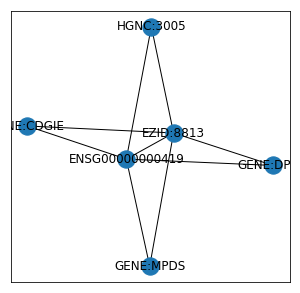

In [12]:
# an example of a valid cluster - EZID is uniquly mapped to ENSEMBL
plt.figure(figsize=(5,5))
show_cluster(ensg_ezid_valid[1]) 

,0,1,SOURCE,EDGE
9585,EZID:100126323,HGNC:33674,MYGENE,1
55678,EZID:100126323,GENE:MIR924,MYGENE,1
55679,EZID:100126323,GENE:MIRN924,MYGENE,1
55680,EZID:100126323,GENE:HSA-MIR-924,MYGENE,1


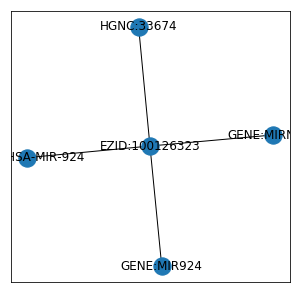

In [13]:
# an example of EZID not mapped to Ensembl
plt.figure(figsize=(5,5))
show_cluster(ensg_ezid_void[0]) 

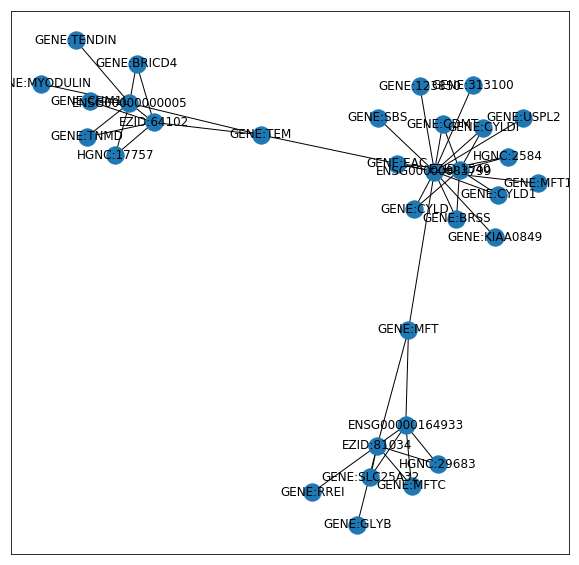

In [14]:
# weird example (one of many many cases...)
plt.figure(figsize=(10,10))
show_cluster(ensg_ezid_error[0]);


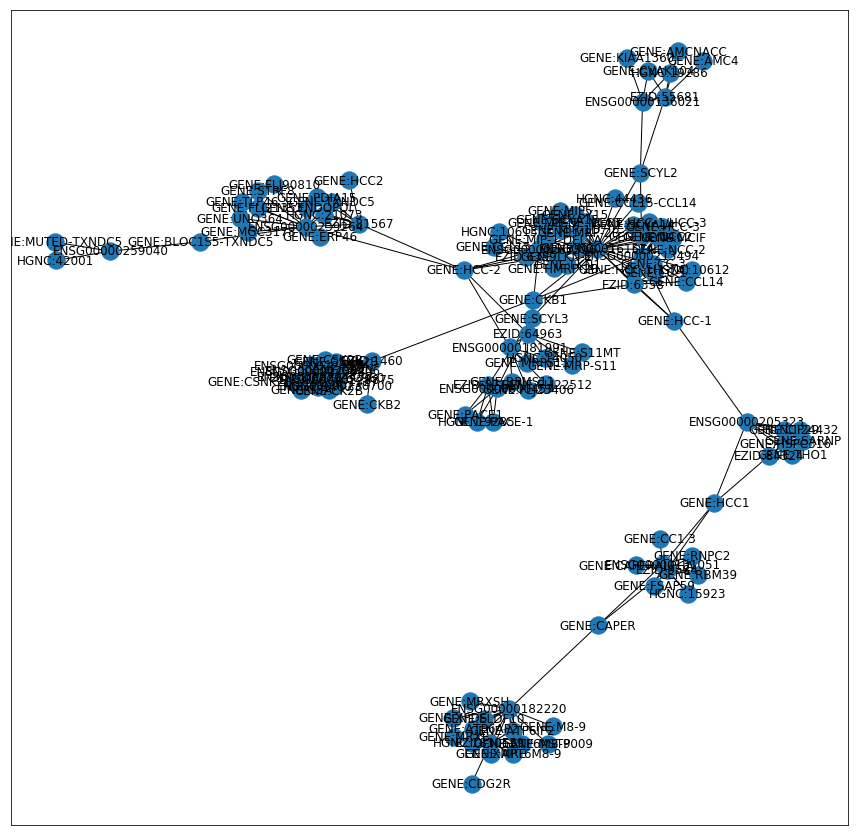

In [15]:
# weird example (one of many many cases...)
plt.figure(figsize=(15,15))
show_cluster(ensg_ezid_error[1]);
